<IPython.core.display.Javascript object>


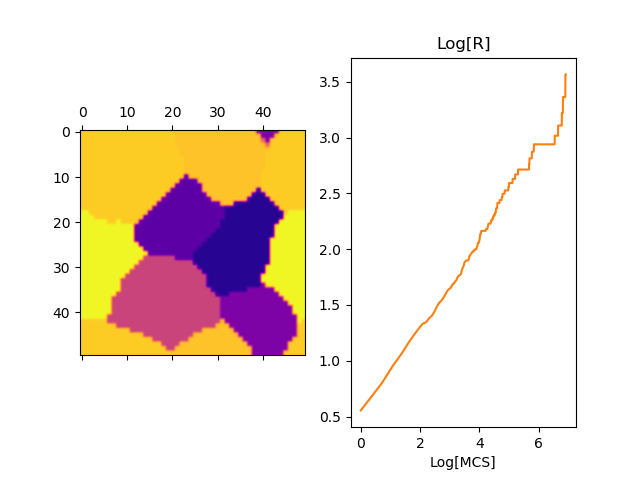

1      824
2      512
3      365
4      296
5      245
6      213
7      191
8      175
9      170
10      158
11      151
12      140
13      128
14      120
15      116
16      110
17      105
18      99
19      95
20      93
21      91
22      86
23      85
24      82
25      80
26      76
27      74
28      73
29      72
30      68
31      64
32      62
33      58
34      57
35      56
36      56
37      56
38      55
39      52
40      51
41      50
42      49
43      48
44      48
45      47
46      47
47      46
48      46
49      46
50      44
51      43
52      41
53      41
54      40
55      38
56      35
57      35
58      33
59      33
60      33
61      33
62      33
63      33
64      33
65      33
66      33
67      33
68      32
69      32
70      32
71      32
72      31
73      30
74      29
75      29
76      29
77      29
78      29
79      29
80      28
81      28
82      27
83      27
84      27
85      27
86      26
87      26
88      25
89      25
90      25
91

729      6
730      6
731      6
732      6
733      6
734      6
735      6
736      6
737      6
738      6
739      6
740      6
741      6
742      6
743      6
744      6
745      6
746      6
747      6
748      6
749      6
750      6
751      6
752      6
753      6
754      6
755      6
756      6
757      6
758      6
759      6
760      6
761      6
762      6
763      6
764      6
765      6
766      6
767      6
768      6
769      6
770      6
771      6
772      5
773      5
774      5
775      5
776      5
777      5
778      5
779      5
780      5
781      5
782      5
783      5
784      5
785      5
786      5
787      5
788      5
789      5
790      5
791      5
792      5
793      5
794      5
795      5
796      5
797      5
798      5
799      5
800      5
801      5
802      5
803      5
804      5
805      5
806      5
807      5
808      5
809      5
810      5
811      5
812      5
813      5
814      5
815      5
816      5
817      5
818      5
819      5

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.optimize as opt
from numba import njit
%matplotlib notebook

def largest_primes_under(N):
    n = N - 1
    while n >= 2:
        if all(n % d for d in range(2, int(n ** 0.5 + 1))):
            return n
        n -= 1

@njit
def Neighbors(Lattice,i,j,n=1):
    ''' Returns an flat array of all neighboring sites in the n-th coordination sphere including the center'''
    N, M = Lattice.shape
    rows = np.array([(i-1) % N, i, (i+1) % N])
    cols = np.array([(j-1) % N, j, (j+1) % M])
    return Lattice[rows,:][:,cols].flatten()

@njit
def calc_dE(Lattice, x, y, z):
    N, M = Lattice.shape
    old_energy = 0
    new_energy = 0
    for i in [0,1,-1]:
        for j in [0,1,-1]:
            if i == 0 and j == 0:
                continue
            if Lattice[x%N,y%M] == Lattice[(x+i)%N,(y+j)%M]:
                old_energy += 1
            elif z == Lattice[(x+i)%N,(y+j)%M]:
                new_energy += 1
    return old_energy-new_energy

N, M = 50,50
orientations = N*M

beta = 2.5
MCS = int(1000)

a = largest_primes_under(N*M)
L = np.random.randint(1,orientations+1,size=(N,M))

ims=[]
logt_all=[]
logr_all=[]

fig, axs = plt.subplots(nrows=1, ncols=2)
mat = axs[0].matshow(L,animated=True,cmap = plt.get_cmap('plasma', orientations+1), vmin = -0.5, vmax = orientations+0.5, interpolation='kaiser')
mvt = axs[1].plot(logt_all,logr_all)
axs[1].set(title='Log[R]', xlabel='Log[MCS]')

for t in range(1,MCS+1):
    rand = np.random.randint(N*M)
    for i in range(0,N**2):
        index = (a*i + rand) % (N**2)
        x = index % N
        y = index // N
        n = Neighbors(L,x,y)
        if len(n)-1 == 0:
            continue
        else:
            z = np.random.choice(n)
        dE = calc_dE(L,x,y,z)
        if  (dE < 0):
            L[x%N,y%N] = z
        elif np.random.sample() < np.exp(-dE*beta):
            L[x%N,y%N] = z
    
    ims.append((axs[0].matshow(L,animated=True,cmap = plt.get_cmap('plasma', orientations+1), vmin = -0.5, vmax = orientations+0.5, interpolation='kaiser'),))

    logt_all.append(np.log(t))                            # store log(MCS)
    logr_all.append(0.5*np.log(N*M/len(np.unique(L))))    # store log(grain size)
    print(t,"    ",len(np.unique(L)))                     # outputs the unique number of grains at each MCS

ani = animation.ArtistAnimation(fig,ims,interval=100,blit=True)   # Disaply animation of microstructure
lines = axs[1].plot(logt_all,logr_all)     # Plot Log[MCS] vs Log[Grain Size]
m, c = np.polyfit(logt_all,logr_all,1)     # Fit straight line to determine gradient (m) and intercept (c)
axs[1].annotate('gradient = (%.1f)'%(m),(0,0))

print('Gradient: ',m,'  Intercept: ',c)

fig.show()